In [2]:
from docplex.mp.model import Model
from docplex.mp.conflict_refiner import ConflictRefiner

import itertools as iter
from itertools import product

import time
import pandas as pd
import numpy as np

import random

from matplotlib import pyplot as plt


from mpl_toolkits.mplot3d import Axes3D


In [3]:
def f(x):
    return 10/(x[0]+x[1])

def gradf(x):
    return np.array((-1/(x[0]+x[1])**2,-1/(x[0]+x[1])**2)).reshape((2,))

def s(x):
    return "("+(", ".join(x.astype(str)))+")"

In [4]:
eps = 100
eps2 = 0.0001
gamma = 1

n=12 #n+1 = datos
h=(5-eps2)/n

In [5]:
D = np.mgrid[eps2:5+h/2:h, eps2:5+h/2:h].reshape(2,-1).T
print(len(D))

169


In [5]:
normf = sum(f(x) for x in D)
M = max(f(x) for x in D)

print(normf)
print(M)

50478.07783006588
50000.0


In [6]:
def create_model2(eps,eps2, gamma1,gamma2, D, M):

    model = Model(name="IdeaSH1")


    #Variables#
    G = dict()
    H = dict()

    A = dict()

    for x in D:
        G[s(x)]      = model.binary_var(name="G(%s)"%x)
        H[s(x)]      = model.continuous_var(name="H(%s)"%x, lb= None)
        
    for x,y in iter.product(D,D):
        A[s(x),s(y)] = model.binary_var(name="A(%s,%s)"%(x,y))
        
    #Restricciones#

    model.add_constraint(normf <= sum(H[s(x)] for x in D) + eps, ctname= "(9)") # NORMA 1
    #model.add_constraints((f(x) <= H[s(x)] + eps for x in D), names= "(13)")# NORMA INFINITO
    
    ##model.add_constraints((H[s(x)] >= f(y) + np.dot(gradf(y),(x-y)) - (1-G[s(y)])*M for x in D for y in D))#,names= ("(10,(%s,%s))"%(x,y) for x in D for y in D))
    model.add_constraints((H[s(x)] == sum(A[s(x),s(y)]*(f(y) + np.dot(gradf(y),(x-y)))for y in D) for x in D))#
    model.add_constraints(A[s(x),s(y)] <= G[s(y)] for x in D for y in D)
    model.add_constraints(sum(A[s(x),s(y)] for y in D) <= 1 for x in D)

    #FO#
    
    FO = model.linear_expr(name="FO").add(sum(G[s(x)] + gamma2*H[s(x)] for x in D))

    model.set_objective("min", FO)

    return model

In [7]:
def create_model(eps,eps2, gamma1,gamma2, D, M):

    model = Model(name="IdeaSH1")


    #Variables#
    G = dict()
    H = dict()

    gt = dict()

    for x in D:
        G[s(x)]      = model.binary_var(name="G(%s)"%x)
        H[s(x)]      = model.continuous_var(name="H(%s)"%x, lb=0, ub=f(x))
        #gt[s(x)] = [].append(y for y in D if np.greater(x,y).all())
        
    #Restricciones#

    #model.add_constraint(normf <= sum(H[s(x)] for x in D) + eps, ctname= "(9)") NORMA 1
    model.add_constraints((f(x) <= H[s(x)] + eps for x in D), names= "(13)")# NORMA INFINITO
    
    model.add_constraints((H[s(x)] >= f(y) + np.dot(gradf(y),(x-y)) - (1-G[s(y)])*M for x in D for y in D))#,names= ("(10,(%s,%s))"%(x,y) for x in D for y in D))
    model.add_constraints((H[s(x)] <= sum(G[s(y)]*f(x) for y in D if np.greater(x,y).all() and (x[0]>eps2 or x[1]>eps2)) for x in D))#, names= ("(13,(%s))"%x for x in D))

    #FO#
    
    FO = model.linear_expr(name="FO").add(sum(G[s(x)] + gamma2*H[s(x)] for x in D))

    model.set_objective("min", FO)

    return model


In [8]:
modelo = create_model2(eps,eps2,0,gamma,D,M)

In [9]:
modelo.parameters.preprocessing.symmetry.set(0)
modelo.solve(log_output = True)

Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              202001241
CPXPARAM_Preprocessing_Symmetry                  0
Tried aggregator 2 times.
MIP Presolve eliminated 528 rows and 528 columns.
Aggregator did 170 substitutions.
Reduced MIP has 28202 rows, 28201 columns, and 112132 nonzeros.
Reduced MIP has 28201 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.53 sec. (334.62 ticks)
Found incumbent of value 51424.658568 after 0.76 sec. (405.80 ticks)
Probing time = 0.11 sec. (9.76 ticks)
Tried aggregator 1 time.
Reduced MIP has 28202 rows, 28201 columns, and 112132 nonzeros.
Reduced MIP has 28201 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.28 sec. (193.24 ticks)
Probing time = 0.05 sec. (9.74 ticks)
Clique table members: 28201.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to

docplex.mp.solution.SolveSolution(obj=50381.3,values={G([0.0001 0.0001])..

In [10]:
print(modelo.get_solve_status().value)

2


In [11]:
modelo.print_information()

Model: IdeaSH1
 - number of variables: 28899
   - binary=28730, integer=0, continuous=169
 - number of constraints: 28900
   - linear=28900
 - parameters:
     parameters.preprocessing.symmetry = 0
 - objective: minimize
 - problem type is: MILP


In [12]:
#print(modelo.export_to_string())

In [13]:
for x in D:
    a = modelo.get_var_by_name("G(%s)"%x).solution_value
    b = modelo.get_var_by_name("H(%s)"%x).solution_value
    
    if a != 0:
        print(a,b, x)

for x in D:
    a = modelo.get_var_by_name("G(%s)"%x).solution_value
    b = modelo.get_var_by_name("H(%s)"%x).solution_value
    
    if a != 0 or b != 0:
        print(a,b, x)

1.0 50000.0 [0.0001 0.0001]
1.0 23.98896507606501 [4.16758333e-01 1.00000000e-04]
1.0 50000.0 [0.0001 0.0001]
0 23.98896507606501 [1.00000000e-04 4.16758333e-01]
0 21.59121950934935 [1.00000000e-04 8.33416667e-01]
0 19.19347394263369 [1.000000e-04 1.250075e+00]
0 16.79572837591803 [1.00000000e-04 1.66673333e+00]
0 4.807000542339733 [1.000000e-04 3.750025e+00]
0 2.409254975624073 [1.00000000e-04 4.16668333e+00]
1.0 23.98896507606501 [4.16758333e-01 1.00000000e-04]
0 21.59121950934935 [0.41675833 0.41675833]
0 19.19347394263369 [0.41675833 0.83341667]
0 16.79572837591803 [0.41675833 1.250075  ]
0 4.807000542339733 [0.41675833 3.33336667]
0 2.409254975624073 [0.41675833 3.750025  ]
0 21.59121950934935 [8.33416667e-01 1.00000000e-04]
0 19.19347394263369 [0.83341667 0.41675833]
0 16.79572837591803 [0.83341667 0.83341667]
0 4.807000542339733 [0.83341667 2.91670833]
0 2.409254975624073 [0.83341667 3.33336667]
0 19.19347394263369 [1.250075e+00 1.000000e-04]
0 16.79572837591803 [1.250075   0.41

In [14]:
for x in D:
    a = modelo.get_var_by_name("G(%s)"%x).solution_value
    b = modelo.get_var_by_name("H(%s)"%x).solution_value

    print(a,b)

1.0 50000.0
0 23.98896507606501
0 21.59121950934935
0 19.19347394263369
0 16.79572837591803
0 0
0 0
0 0
0 0
0 4.807000542339733
0 2.409254975624073
0 0
0 0
1.0 23.98896507606501
0 21.59121950934935
0 19.19347394263369
0 16.79572837591803
0 0
0 0
0 0
0 0
0 4.807000542339733
0 2.409254975624073
0 0
0 0
0 0
0 21.59121950934935
0 19.19347394263369
0 16.79572837591803
0 0
0 0
0 0
0 0
0 4.807000542339733
0 2.409254975624073
0 0
0 0
0 0
0 0
0 19.19347394263369
0 16.79572837591803
0 0
0 0
0 0
0 0
0 4.807000542339733
0 2.409254975624073
0 0
0 0
0 0
0 0
0 0
0 16.79572837591803
0 0
0 0
0 0
0 7.204746109055392
0 0
0 2.409254975624073
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 7.204746109055389
0 4.807000542339733
0 2.4092549756240693
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 7.204746109055392
0 4.807000542339733
0 2.409254975624073
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 7.204746109055392
0 4.807000542339733
0 2.409254975624073
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 7.204746109055392
0 4.807000542339733
0 2.4

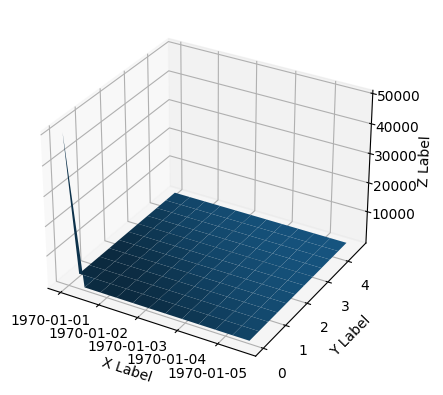

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = y = np.arange(eps2, 5, h)
X, Y = np.meshgrid(x, y)
zs = np.array([f((x,y)) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z = zs.reshape(X.shape)

ax.plot_surface(X, Y, Z)

for x in D:
    a = modelo.get_var_by_name("G(%s)"%x).solution_value
    b = modelo.get_var_by_name("H(%s)"%x).solution_value
    
    if a != 0:
        ax.plot_date(x[0],x[1],b)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()